1. Loading a torchdms model from a file:

In [5]:
import torch

def load_model(model_path: str):
    model = torch.load(model_path)
    return model

model_path = "Linear.model"

torchdms_model = load_model(model_path)

2. Evaluating phenotype from the model using input sequences (and labeling)

In [6]:
import pandas, csv
from Bio import SeqIO

# take in FASTA file of DMS sequences and translate to amino acid sequences (excluding naive)
def get_aa_seqs_from_fasta(fasta_path: str):
    aa_seqs = []
    for record in SeqIO.parse(fasta_path, 'fasta'):
        if record.id.lower() != 'naive':
            aa_seq = record.seq.translate()
            aa_seqs.append(str(aa_seq))
    return aa_seqs

# take in csv file of DMS sequences (excluding naive)
def get_aa_seqs_from_csv(csv_path: str):
    aa_seqs = []
    with open(csv_path, 'r') as F:
        reader = csv.DictReader(F)
        for row in reader:
            if str(row['name']).lower() != 'naive':
                aa_seqs.append(row['aa_sequence'])
    return aa_seqs

# evaluate sequences using torchdms model and return the evaluation as a pandas dataframe
def evaluate(torchdms_model, seqs: list[str], phenotype_names: list[str]):
    aa_seq_one_hot = torch.stack([torchdms_model.seq_to_binary(seq) for seq in seqs])
    try:
        labeled_evaluation = pandas.DataFrame(torchdms_model(aa_seq_one_hot).detach().numpy(), columns=phenotype_names)
    except ValueError:
        print("Incorrect number of column labels for phenotype data")
    return labeled_evaluation

seqs = get_aa_seqs_from_csv('gctree-node-data.csv')

phenotype_evaluation = evaluate(torchdms_model, seqs, ['delta_log10_KD', 'expression'])

3. Infer fitness by calculating the fraction of antigen bound
Uses Hill equation to infer fraction of antibodies that have antigen bound (theta)

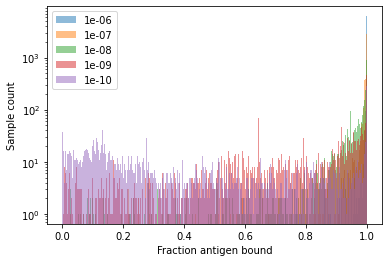

In [9]:
import matplotlib.pyplot as plt
import numpy

def get_frac_antigen_bound(delta_log10_KD: float, log10_naive_KD: float, concentration_antigen: float):
    log10_KD  = delta_log10_KD + log10_naive_KD
    KD = 10**log10_KD
    # Hill equation with n = 1:
    theta = concentration_antigen/(KD + concentration_antigen)
    return theta

log10_naive_KD = -10.43

plt.figure()
for c in range(6,11): # concentration of antigen from 10^-6 to 10^-10
    concentration_antigen = 10**(-1*c)
    antigen_bound_fracs = []
    for delta_log10_KD in phenotype_evaluation['delta_log10_KD']:
        antigen_bound_fracs.append(get_frac_antigen_bound(delta_log10_KD, log10_naive_KD, concentration_antigen))
    plt.hist(antigen_bound_fracs, alpha=0.5, label=str(concentration_antigen), bins=numpy.arange(0, 1.001, .001))

plt.yscale("log")
plt.xlabel("Fraction antigen bound")
plt.ylabel("Sample count")
plt.legend()
plt.show()